## Load Dataset and libraries 

In [ ]:
import numpy as np
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import os
import re
import skimage
from skimage.metrics import structural_similarity as ssim
#from skimage.metrics import mean_squared_error
from image_similarity_measures.quality_metrics import fsim, issm
import pandas as pd
from sewar.full_ref import mse, rmse, psnr, uqi,ergas, scc, rase, sam, msssim, vifp


# Importing training images and sketches 

In [ ]:

# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 256

image_path = '/CUHK Dataset/CUHK_training_cropped_photos'
img_array = []

sketch_path = '/CUHK Dataset/CUHK_training_cropped_sketches'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))

for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    
    #appending normal normal image    
    img_array.append(img_to_array(image))

    # Image Augmentation
    
    # horizontal flip 
    img1 = cv2.flip(image,1)
    img_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    img_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    img_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    img_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    img_array.append(img_to_array(img7))

for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(img_to_array(image))

    #Image Augmentation
    
    # horizontal flip 
    img1 = cv2.flip(image,1)
    sketch_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    sketch_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    sketch_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    sketch_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    sketch_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    sketch_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    sketch_array.append(img_to_array(img7))



100%|██████████| 88/88 [00:17<00:00,  5.08it/s]


# Importing testing images and sketches

-



In [ ]:
image_path_test = '/CUHK Dataset/CUHK_testing_cropped_photos'
test_img_array = []

sketch_path_test = '/CUHK Dataset/CUHK_testing_cropped_sketches'
test_sketch_array = []

test_image_file = sorted_alphanumeric(os.listdir(image_path_test))
test_sketch_file = sorted_alphanumeric(os.listdir(sketch_path_test))

for i in tqdm(test_image_file):
    image = cv2.imread(image_path_test + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    
    #appending normal normal image    
    test_img_array.append(img_to_array(image))

for i in tqdm(test_sketch_file):
    image = cv2.imread(sketch_path_test + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    test_sketch_array.append(img_to_array(image))

100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


In [ ]:
print("Total number of sketch images:",len(sketch_array))
print("Total number of images:",len(img_array))
print("Total number of sketch images:",len(test_sketch_array))
print("Total number of images:",len(test_img_array))

Total number of sketch images: 704
Total number of images: 704
Total number of sketch images: 100
Total number of images: 100


# Reshaping dataset

In [ ]:
train_sketch_image = sketch_array
train_image = img_array
test_sketch_image = test_sketch_array
test_image = test_img_array
# reshaping
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test color image shape',test_image.shape)

Train color image shape: (704, 256, 256, 3)
Test color image shape (100, 256, 256, 3)


# Conv AE Model 

## Define model (3 layers)

In [ ]:
import keras
from keras import layers

input_img = keras.Input(shape=(256, 256, 3))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding = 'same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

model_convAE = keras.Model(input_img, decoded)

# Separable conv encoder
model_convAE_encoder = keras.Model(input_img, encoded)

In [ ]:
model_convAE.summary()

## Training and Test

Training

Epoch 1/200
6/6 [==============================] - 13s 494ms/step - loss: 0.6911 - val_loss: 0.6834
Epoch 2/200
6/6 [==============================] - 1s 227ms/step - loss: 0.6693 - val_loss: 0.6391
Epoch 3/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5813 - val_loss: 0.4974
Epoch 4/200
6/6 [==============================] - 1s 243ms/step - loss: 0.4438 - val_loss: 0.5432
Epoch 5/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4342 - val_loss: 0.4666
Epoch 6/200
6/6 [==============================] - 1s 229ms/step - loss: 0.4244 - val_loss: 0.4622
Epoch 7/200
6/6 [==============================] - 1s 223ms/step - loss: 0.4103 - val_loss: 0.4688
Epoch 8/200
6/6 [==============================] - 1s 226ms/step - loss: 0.4034 - val_loss: 0.4525
Epoch 9/200
6/6 [==============================] - 1s 226ms/step - loss: 0.3944 - val_loss: 0.4508
Epoch 10/200
6/6 [==============================] - 1s 220ms/step - loss: 0.3854 - val_loss: 0.4414
Epoch 11

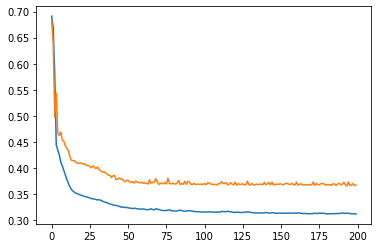

In [ ]:
from keras.callbacks import TensorBoard

model_convAE.compile(optimizer='adam', loss='binary_crossentropy')

model_convAE.fit(train_image, train_sketch_image,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(test_image, test_sketch_image),
                callbacks=[TensorBoard(log_dir='/tmp/model_convAE')])

plt.plot(model_convAE.history.history["loss"])
plt.plot(model_convAE.history.history["val_loss"])

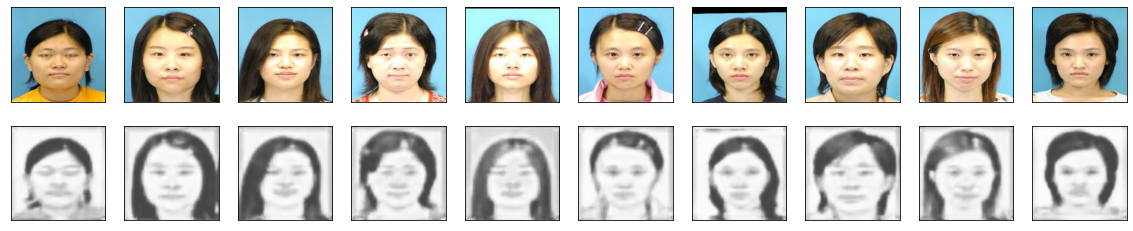

In [ ]:
decoded_imgs = model_convAE.predict(test_image)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_image[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
results = {"SSIM":[ssim(test_image,decoded_imgs, multichannel = True)] , 
        "FSIM": [fsim(test_image.reshape(100,256,256*3),decoded_imgs.reshape(100,256,256*3))]
        }

In [ ]:
test_image.shape,decoded_imgs.shape

((100, 256, 256, 3), (100, 256, 256, 3))

In [ ]:
f2s_similarity_scores = pd.DataFrame(results, index = ["ConvAE (3 Layers)"])
print(f2s_similarity_scores)

                       SSIM      FSIM
ConvAE (3 Layers)  0.554746  0.821289


## 5 Layers

## Define the model (5 layers)

In [ ]:
input_img = keras.Input(shape=(256, 256, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding = 'same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

model_convAE = keras.Model(input_img, decoded)

# Separable conv encoder
model_convAE_encoder = keras.Model(input_img, encoded)

##Training and testing

Epoch 1/200
6/6 [==============================] - 5s 565ms/step - loss: 0.6912 - val_loss: 0.6858
Epoch 2/200
6/6 [==============================] - 2s 290ms/step - loss: 0.6734 - val_loss: 0.6388
Epoch 3/200
6/6 [==============================] - 2s 282ms/step - loss: 0.5616 - val_loss: 0.5685
Epoch 4/200
6/6 [==============================] - 2s 295ms/step - loss: 0.4918 - val_loss: 0.5006
Epoch 5/200
6/6 [==============================] - 2s 292ms/step - loss: 0.4695 - val_loss: 0.4854
Epoch 6/200
6/6 [==============================] - 2s 297ms/step - loss: 0.4467 - val_loss: 0.4747
Epoch 7/200
6/6 [==============================] - 2s 297ms/step - loss: 0.4309 - val_loss: 0.4680
Epoch 8/200
6/6 [==============================] - 2s 294ms/step - loss: 0.4176 - val_loss: 0.4578
Epoch 9/200
6/6 [==============================] - 2s 294ms/step - loss: 0.4061 - val_loss: 0.4500
Epoch 10/200
6/6 [==============================] - 2s 293ms/step - loss: 0.3950 - val_loss: 0.4450
Epoch 11/

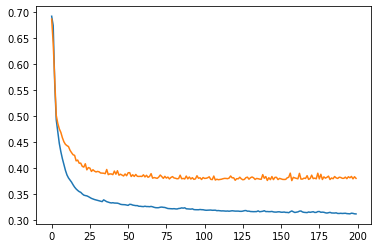

In [ ]:
from keras.callbacks import TensorBoard

model_convAE.compile(optimizer='adam', loss='binary_crossentropy')

model_convAE.fit(train_image, train_sketch_image,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(test_image, test_sketch_image),
                callbacks=[TensorBoard(log_dir='/tmp/model_convAE')])

plt.plot(model_convAE.history.history["loss"])
plt.plot(model_convAE.history.history["val_loss"])

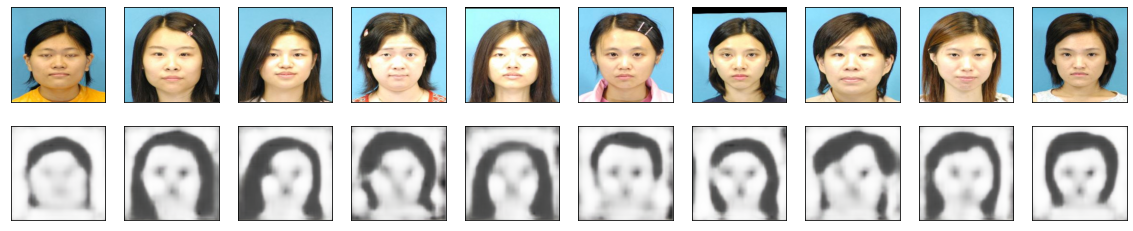

In [ ]:
decoded_imgs = model_convAE.predict(test_image)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_image[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
results = {"SSIM":[ssim(test_image,decoded_imgs, multichannel = True)] , 
        "FSIM": [fsim(test_image.reshape(100,256,256*3),decoded_imgs.reshape(100,256,256*3))]
        }

In [ ]:
data = pd.DataFrame(results, index = ["ConvAE (5 Layers)"])

f2s_similarity_scores = f2s_similarity_scores.append(data)
print(f2s_similarity_scores)


                       SSIM      FSIM
ConvAE (3 Layers)  0.554746  0.821289
ConvAE (5 Layers)  0.442946  0.774358


# Deep AE

## Reshape dataset

In [ ]:
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE*SIZE*3))
train_image = np.reshape(train_image, (len(train_image),SIZE*SIZE*3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE*SIZE*3))
test_image = np.reshape(test_image, (len(test_image),SIZE*SIZE*3))
print('Test color image shape',test_image.shape)

Train color image shape: (704, 196608)
Test color image shape (100, 196608)


## Define model (3+3 layers)

In [ ]:
# define a 3+3 deep autoencoder
input_img = keras.Input(shape=(SIZE*SIZE*3))
encoded = keras.layers.Dense(SIZE*3, activation='relu')(input_img)
encoded = keras.layers.Dense(128, activation='relu')(encoded)
encoded = keras.layers.Dense(64, activation='relu')(encoded)

decoded = keras.layers.Dense(128, activation='relu')(encoded)
decoded = keras.layers.Dense(SIZE*3, activation='relu')(decoded)
decoded = keras.layers.Dense(SIZE*SIZE*3, activation='sigmoid')(decoded)

model_DAE = keras.Model(input_img, decoded)

# Claim a separate decoder model
model_DAE_encoder = keras.Model(input_img, encoded)

# Claim a separate decoder model
decoder_input = keras.Input(shape=(encoded.shape[1]))
# Retrieve the last layer of the autoencoder model
decoder_layer = model_DAE.layers[-3](decoder_input)
decoder_layer = model_DAE.layers[-2](decoder_layer)
decoder_layer = model_DAE.layers[-1](decoder_layer)
# Create the decoder model
model_DAE_decoder = keras.Model(decoder_input, decoder_layer)

## Training and testing

Epoch 1/200
6/6 [==============================] - 2s 217ms/step - loss: 0.5121 - val_loss: 0.4743
Epoch 2/200
6/6 [==============================] - 1s 161ms/step - loss: 0.3958 - val_loss: 0.4298
Epoch 3/200
6/6 [==============================] - 1s 159ms/step - loss: 0.3568 - val_loss: 0.4067
Epoch 4/200
6/6 [==============================] - 1s 163ms/step - loss: 0.3405 - val_loss: 0.4047
Epoch 5/200
6/6 [==============================] - 1s 157ms/step - loss: 0.3290 - val_loss: 0.3986
Epoch 6/200
6/6 [==============================] - 1s 162ms/step - loss: 0.3212 - val_loss: 0.3987
Epoch 7/200
6/6 [==============================] - 1s 161ms/step - loss: 0.3154 - val_loss: 0.4149
Epoch 8/200
6/6 [==============================] - 1s 167ms/step - loss: 0.3110 - val_loss: 0.4151
Epoch 9/200
6/6 [==============================] - 1s 165ms/step - loss: 0.3066 - val_loss: 0.4011
Epoch 10/200
6/6 [==============================] - 1s 164ms/step - loss: 0.3029 - val_loss: 0.3985
Epoch 11/

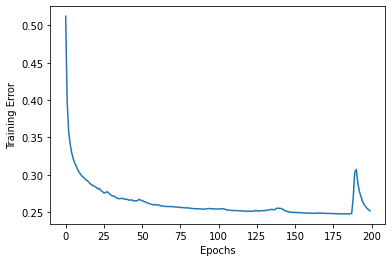

In [ ]:
model_DAE.compile(optimizer='adam', loss='binary_crossentropy')

hist = model_DAE.fit(train_image, train_sketch_image,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(test_image, test_sketch_image))

plt.plot(hist.history["loss"]);
plt.xlabel('Epochs');
plt.ylabel('Training Error');

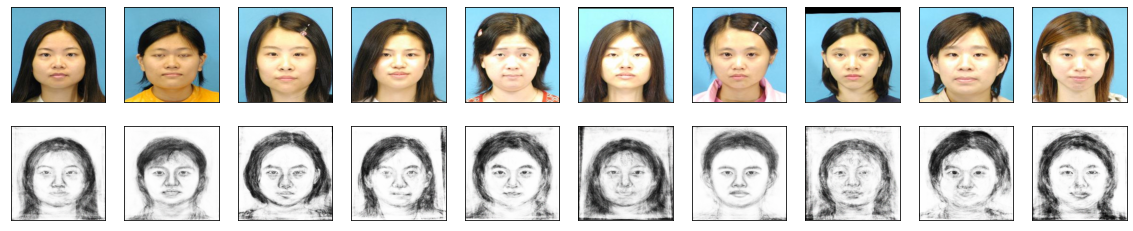

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = model_DAE_encoder.predict(test_image)
decoded_imgs = model_DAE_decoder.predict(encoded_imgs)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_image[i].reshape(256, 256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(256, 256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
data = {"SSIM":[ssim(test_sketch_image,decoded_imgs)] , 
        "FSIM": [fsim(test_sketch_image.reshape(100,256,256*3),decoded_imgs.reshape(100,256,256*3))]
        }

In [ ]:
data = pd.DataFrame(data, index = ["DeepAE (3 Layers)"])

print(data)

                       SSIM      FSIM
DeepAE (3 Layers)  0.478332  0.796538


## Define the model (5 layers)

In [ ]:
# define a 3+3 deep autoencoder
input_img = keras.Input(shape=(SIZE*SIZE*3))
encoded = keras.layers.Dense(SIZE*3, activation='relu')(input_img)
encoded = keras.layers.Dense(256*2, activation='relu')(encoded)
encoded = keras.layers.Dense(256, activation='relu')(encoded)
encoded = keras.layers.Dense(128, activation='relu')(encoded)
encoded = keras.layers.Dense(64, activation='relu')(encoded)

decoded = keras.layers.Dense(128, activation='relu')(encoded)
decoded = keras.layers.Dense(256, activation='relu')(decoded)
decoded = keras.layers.Dense(256*2, activation='relu')(decoded)
decoded = keras.layers.Dense(256*3, activation='relu')(decoded)
decoded = keras.layers.Dense(256*256*3, activation='sigmoid')(decoded)

model_DAE = keras.Model(input_img, decoded)

model_DAE_encoder = keras.Model(input_img, encoded)

# Claim a separate decoder model
decoder_input = keras.Input(shape=(encoded.shape[1]))
# Retrieve the last layer of the autoencoder model
decoder_layer = model_DAE.layers[-5](decoder_input)
decoder_layer = model_DAE.layers[-4](decoder_layer)
decoder_layer = model_DAE.layers[-3](decoder_layer)
decoder_layer = model_DAE.layers[-2](decoder_layer)
decoder_layer = model_DAE.layers[-1](decoder_layer)
# Create the decoder model
model_DAE_decoder = keras.Model(decoder_input, decoder_layer)


## Training and testing (5 layers)

Epoch 1/200
3/3 [==============================] - 2s 462ms/step - loss: 0.5221 - val_loss: 1.0949
Epoch 2/200
3/3 [==============================] - 1s 367ms/step - loss: 0.4075 - val_loss: 0.6956
Epoch 3/200
3/3 [==============================] - 1s 363ms/step - loss: 0.3904 - val_loss: 0.9252
Epoch 4/200
3/3 [==============================] - 1s 356ms/step - loss: 0.3757 - val_loss: 1.0363
Epoch 5/200
3/3 [==============================] - 1s 352ms/step - loss: 0.3637 - val_loss: 0.9839
Epoch 6/200
3/3 [==============================] - 1s 363ms/step - loss: 0.3560 - val_loss: 1.0634
Epoch 7/200
3/3 [==============================] - 1s 361ms/step - loss: 0.3508 - val_loss: 1.0279
Epoch 8/200
3/3 [==============================] - 1s 348ms/step - loss: 0.3465 - val_loss: 1.0299
Epoch 9/200
3/3 [==============================] - 1s 363ms/step - loss: 0.3429 - val_loss: 1.0182
Epoch 10/200
3/3 [==============================] - 1s 369ms/step - loss: 0.3401 - val_loss: 1.0140
Epoch 11/

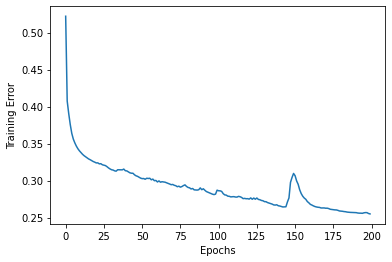

In [ ]:
model_DAE.compile(optimizer='adam', loss='binary_crossentropy')

hist = model_DAE.fit(train_image, train_sketch_image,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(test_sketch_image, test_image))

plt.plot(hist.history["loss"]);
plt.xlabel('Epochs');
plt.ylabel('Training Error');

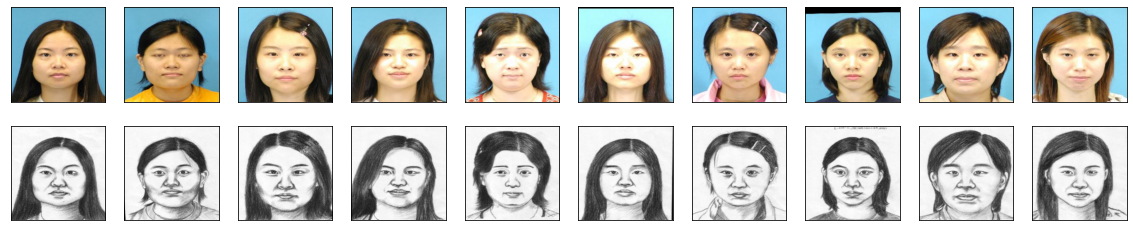

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = model_DAE_encoder.predict(test_image)
decoded_imgs = model_DAE_decoder.predict(encoded_imgs)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_image[i].reshape(256, 256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_sketch_image[i].reshape(256, 256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
data = {"SSIM":[ssim(test_sketch_image,decoded_imgs)] , 
        "FSIM": [fsim(test_sketch_image.reshape(100,256,256*3),decoded_imgs.reshape(100,256,256*3))]
        }

In [ ]:
ssim(test_image,decoded_imgs), fsim(test_image.reshape(100,256,256*3),decoded_imgs.reshape(100,256,256*3))

(0.6599104469981563, 0.8041493135367969)

In [ ]:
data = pd.DataFrame(data, index = ["DeepAE (5 Layers)"])

print(data)

                       SSIM      FSIM
DeepAE (5 Layers)  0.477352  0.797646


In [ ]:
data = {"SSIM":[0.578165,0.487824,0.50456,0.48690, 0.210978] , 
        "FSIM": [0.821289,0.774358,0.796538,0.756698,0.67567]
        }

In [ ]:
data = pd.DataFrame(data, index = ["ConvAE (3 Layers)","ConvAE (5 Layers)","DeepAE (3 Layers)","DeepAE (5 Layers)", "LSTM"])

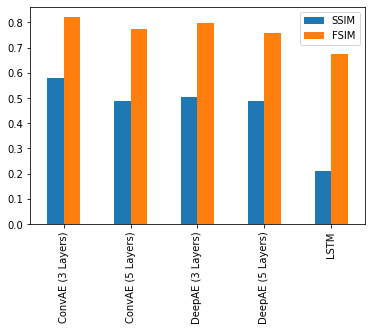

In [ ]:
ax= data.plot.bar()

In [ ]:
data = {"SSIM":[0.523491,0.500631,0.624444,0.65991,0.25656] , 
        "FSIM": [0.795708,0.770828,0.789464,0.80414,0.70476]
        }

In [ ]:
data = pd.DataFrame(data, index = ["ConvAE (3 Layers)","ConvAE (5 Layers)","DeepAE (3 Layers)","DeepAE (5 Layers)", "LSTM"])

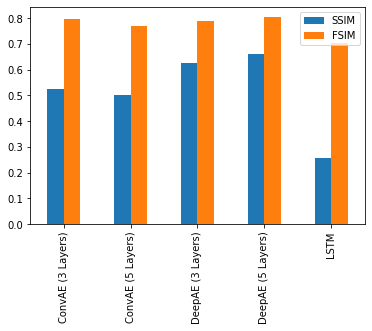

In [ ]:
ax= data.plot.bar()

#LSTM

In [ ]:
train_sketch_image = sketch_array
train_image = img_array
test_sketch_image = test_sketch_array
test_image = test_img_array
# reshaping
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE*3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE*3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE*3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE*3))
print('Test color image shape',test_image.shape)

In [ ]:
import keras
from keras import layers

timesteps = 256  # Length of your sequences
depth = 3
input_dim = 256 *depth

latent_dim = 32

inputs = keras.Input(shape=(timesteps, (input_dim)))
encoded = layers.LSTM(latent_dim)(inputs)

decoded = layers.RepeatVector(timesteps)(encoded)
decoded = layers.LSTM(input_dim, return_sequences=True)(decoded)

model_lstmAE = keras.Model(inputs, decoded)
model_lstmAE_encoder = keras.Model(inputs, encoded)

In [ ]:
from keras.callbacks import TensorBoard

model_lstmAE.compile(optimizer='adam', loss='binary_crossentropy')

model_lstmAE.fit(train_image, train_sketch_image,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(train_sketch_image, train_image),
                callbacks=[TensorBoard(log_dir='/tmp/model_convAE')])
plt.plot(model_lstmAE.history.history["loss"])
plt.plot(model_lstmAE.history.history["val_loss"])

In [ ]:
decoded_imgs = model_lstmAE.predict(test_image)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    ssim_score = ssim(test_sketch_image[i], decoded_imgs[i])
    
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_sketch_image[i].reshape(256,256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(256,256,3))
    plt.gray()
    #ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel(f'SSIM: {ssim_score:.2f}')
plt.show()

In [ ]:
results = {"SSIM":[ssim(test_image,decoded_imgs, multichannel = True)] , 
        "FSIM": [fsim(test_image,decoded_imgs)]
}

In [ ]:
results